In [1]:
import pyspark, os
from pyspark import SparkConf, SparkContext
os.environ["PYSPARK_PYTHON"]="python3"
os.environ["JAVA_HOME"]="/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home"


#start spark local server
import sys, os
from operator import add
import time

os.environ["PYSPARK_PYTHON"]="python3"

import pyspark
from pyspark import SparkConf, SparkContext

#connects our python driver to a local Spark JVM running on the Google Colab server virtual machine
try:
    conf = SparkConf().setMaster("local[*]").set("spark.executor.memory", "1g")
    sc = SparkContext(conf = conf)
except ValueError:
    #it's ok if the server is already started
    pass

def dbg(x):
    """ A helper function to print debugging information on RDDs """
    if isinstance(x, pyspark.RDD):
        print([(t[0], list(t[1]) if 
        isinstance(t[1], pyspark.resultiterable.ResultIterable) else t[1])
           if isinstance(t, tuple) else t
           for t in x.take(100)])
    else:
        print(x)

In [2]:
import itertools
from datetime import date, timedelta
import datetime as dt
import pandas as pd
import os
import urllib.request
from pyspark.sql import SQLContext
from pyspark.sql import Row
sqlContext = SQLContext(sc)

import numpy as np
from newspaper import Article
import nltk
nltk.download('popular', quiet=True)
import time

In [3]:
# generic functions to pull and write data to disk based on date
def get_filename(x):
    date = x.strftime('%Y%m%d')
    return "{}_gdeltdata.csv".format(date)

def intofile(filename):
    try:
        if not os.path.exists(filename):
            date = filename.split("_")[0]
            startdate = date+"000000" #0 hour 0 min 0 sec (start of day)
            enddate = date+"235959" #23 hour 59 min 59 sec (end of day)
            query = queryURLbase + "&startdatetime=" + startdate + "&enddatetime=" + enddate
            with urllib.request.urlopen(query) as testfile, open(filename, 'w') as f:
                f.write(testfile.read().decode())
    except:
        print("Error occurred")

#Creates a list of URL's for every day and saves to disk

In [4]:
def get_urls(row):
    #return row['URL']
    return row['URL'], row['Date'][0:10]

def write_wget(withid):
    url = withid[0][0]
    date = withid[0][1]
    id = withid[1]
    s = 'articles/' + date + "/" + str(id) + ".html " + url
    if not os.path.exists('articles/' + date):
        os.mkdir('articles/' + date)
    if not os.path.exists(os.getcwd()+'/articles/' + date + "/" + str(id) + ".html"):
        print("wget " + s)
        os.system('wget -O ' + s)
    return id,date

In [5]:
def output_keywords(id):
    try:
        filename = "articles/"+str(id[1])+"/"+str(id[0])+".html"
        filenameurl = "file://"+os.getcwd()+'/'+filename
        article = Article(filenameurl)
        with open(filename, 'r', errors="replace") as f:
            s = f.read()
            article.set_html(s)
        if not s:
            return None
        article.parse()
        article.nlp()
        return sorted([k for k in article.keywords])
    except Exception as e:
        if str(e)[10:13] == "dow":
            #404 Empty file
            pass
        else:
            print("\nException: ", id, str(e))
        return []

In [6]:
#Downloads all data
def get_all_keywords(startdate, enddate):
    !rm *.csv
    #!rm -rf articles #Full wipe?
    
    #Creates a list of URL's for every day and saves to disk
    daterange = sc.parallelize(pd.date_range(startdate,enddate))
    #daterange = sc.parallelize(daterange)
    dates = daterange.map(get_filename)
    dates.foreach(intofile)
    
    #Loads url list from disk
    data_urls = sqlContext.read.option("header", "true").csv(dates.collect())
    data_urls = data_urls.dropDuplicates(['Title']) #Remove duplicates
    #dbg(data_urls)
    
    #Downloads contents of all urls to disk
    if not os.path.exists('articles'):
        os.mkdir('articles')   
    all_urls = data_urls.rdd.map(get_urls)
    withids = all_urls.zipWithUniqueId()    
    allids = withids.map(write_wget)
    #dbg(allids)
    
    #All_Keywords is an RDD where each row contains a list of keywords from an individual article
    all_keywords = allids.map(output_keywords)
    all_keywords = all_keywords.filter(lambda x: x!=None) #Remove empty files (404?)
    #dbg(all_keywords)
    
    return all_keywords

In [ ]:
start_time = time.monotonic() 

starts = pd.date_range(start='2020-01-19', end='2020 Jun 03', freq="7d")
ends = pd.date_range(start='2020-01-25', end='2020 Jun 03', freq="7d")
starts = starts.astype(str)
ends = ends.astype(str)
all_keywords = get_all_keywords(starts[0], ends[0])

len_all_articles = all_keywords.count()
support = 0.02 * len_all_articles

all_keywordsflat = all_keywords.flatMap(lambda x: [(i,1) for i in x])
counts = all_keywordsflat.reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[1], False)
counts = counts.filter(lambda x: x[1] > support)

keywords = counts.map(lambda x: x[0]).collect()


end_time = time.monotonic()
print("processing took ",end_time-start_time)

In [7]:
#Creates a bloom filter for effeciently checking if an item is in keywords
def get_bloom(keywords):
    from bloom_filter import BloomFilter
    bloom = BloomFilter(max_elements=len(keywords), error_rate=0.01)
    for word in keywords:
        if word != "coronavirus" and word != "covid19":
            bloom.add(word)
    return bloom

In [95]:
start_time = time.monotonic() 

bloom = keywords 
#bloom = get_bloom(keywords) #comment out to not use the bloom filter

#Creates all keyword pairs that exist within keywords. This works as each element of all_keywords is sorted, there must be a faster way but pyspark can't hash sets.
keypairs = all_keywords.flatMap(lambda x: [(j,1) for j in itertools.combinations([i for i in x if i in bloom], 2)])

keypaircounts = keypairs.reduceByKey(lambda a, b: a + b) \
                        .filter(lambda x: x[1] > support) \
                        .sortBy(lambda x: x[1], False)

end_time = time.monotonic()
print("processing took ",end_time-start_time)

processing took  11.498286017998907


In [8]:
def confscore(s, countlook):
    a = [s[0],       s[1]/countlook[s[0][0]]]
    b = [s[0][::-1], s[1]/countlook[s[0][1]]]
    #lift = [s[0],       (s[1] / len_all_articles)/(  (countlook[s[0][0]]/len_all_articles)  *  (countlook[s[0][1]]/len_all_articles)  )]
    return (a,b)
    #return [lift]


In [109]:
#countlook = dict(counts.collect())
conf = keypaircounts.flatMap(confscore).sortBy(lambda x: x[1], False)
interest = conf.map(lambda s: [s[0], abs(s[1] - countlook[s[0][1]]/len_all_articles)]).sortBy(lambda x: x[1], False)


In [ ]:
#Main does everything above
def main(sup, queryURLbase):
    
    starts = pd.date_range(start='2020-01-19', end='2020 Jun 03', freq="7d")
    ends = pd.date_range(start='2020-01-25', end='2020 Jun 03', freq="7d")
    starts = starts.astype(str)
    ends = ends.astype(str)
    
    for i in range(len(ends)):
        if not os.path.exists('out/' + starts[i] + '.txt'):
            all_keywords = get_all_keywords(starts[i], ends[i])
            len_all_articles = all_keywords.count()
            support = sup * len_all_articles
            #At this point we have downloaded all the data required and just need to manipulate it

            start_time = time.monotonic()

            all_keywordsflat = all_keywords.flatMap(lambda x: [(i,1) for i in x])
            counts = all_keywordsflat.reduceByKey(lambda a, b: a + b).sortBy(lambda x: x[1], False)
            counts = counts.filter(lambda x: x[1] > support)
            keywords = counts.map(lambda x: x[0]).collect()

            bloom = keywords 
            #bloom = get_bloom(keywords) #comment out to not use the bloom filter

            #Creates all keyword pairings. This works as each element of all_keywords is sorted, there must be a faster way but pyspark can't hash sets.
            keypairs = all_keywords.flatMap(lambda x: [(j,1) for j in itertools.combinations([i for i in x if i in bloom], 2)])

            keypaircounts = keypairs.reduceByKey(lambda a, b: a + b) \
                                    .filter(lambda x: x[1] > support) \
                                    .sortBy(lambda x: x[1], False)

            countlook = dict(counts.collect())
            conf = keypaircounts.flatMap(lambda x: confscore(x,countlook)).sortBy(lambda x: x[1], False)
            interest = conf.map(lambda s: [s[0], abs(s[1] - countlook[s[0][1]]/len_all_articles)]).sortBy(lambda x: x[1], False)

            end_time = time.monotonic()
            print("processing for "+ starts[i] + " is",end_time-start_time)


            if not os.path.exists('out'):
                os.mkdir('out')
            with open('out/' + starts[i] + '.txt', 'w') as file:
                for x in interest.collect():
                    file.write(x[0][0] + "," + x[0][1] + "," + str(x[1]) + '\n')
    
    
    
    
queryURLbase = "https://api.gdeltproject.org/api/v2/doc/doc?format=csv&query=(covid19%20or%20corona%20or%20coronavirus)%20sourcecountry:NZ%20sourcelang:eng&mode=artlist&maxrecords=250&sort=hybridrel"
main(0.02, queryURLbase)
    

In [96]:
def topten(y): 
    out = []
    with open('out/'+y, 'r') as file:
        for line in file:
            line = line[:-1]
            line = line.split(',')
            if line[0] not in banlist and line[1] not in banlist:
                line = line[0] + ', ' +line[1]
                out.append(line)
            if len(out) > 9:
                break
        while len(out) <= 9:  
            out.append("~ None ~")
        return out

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


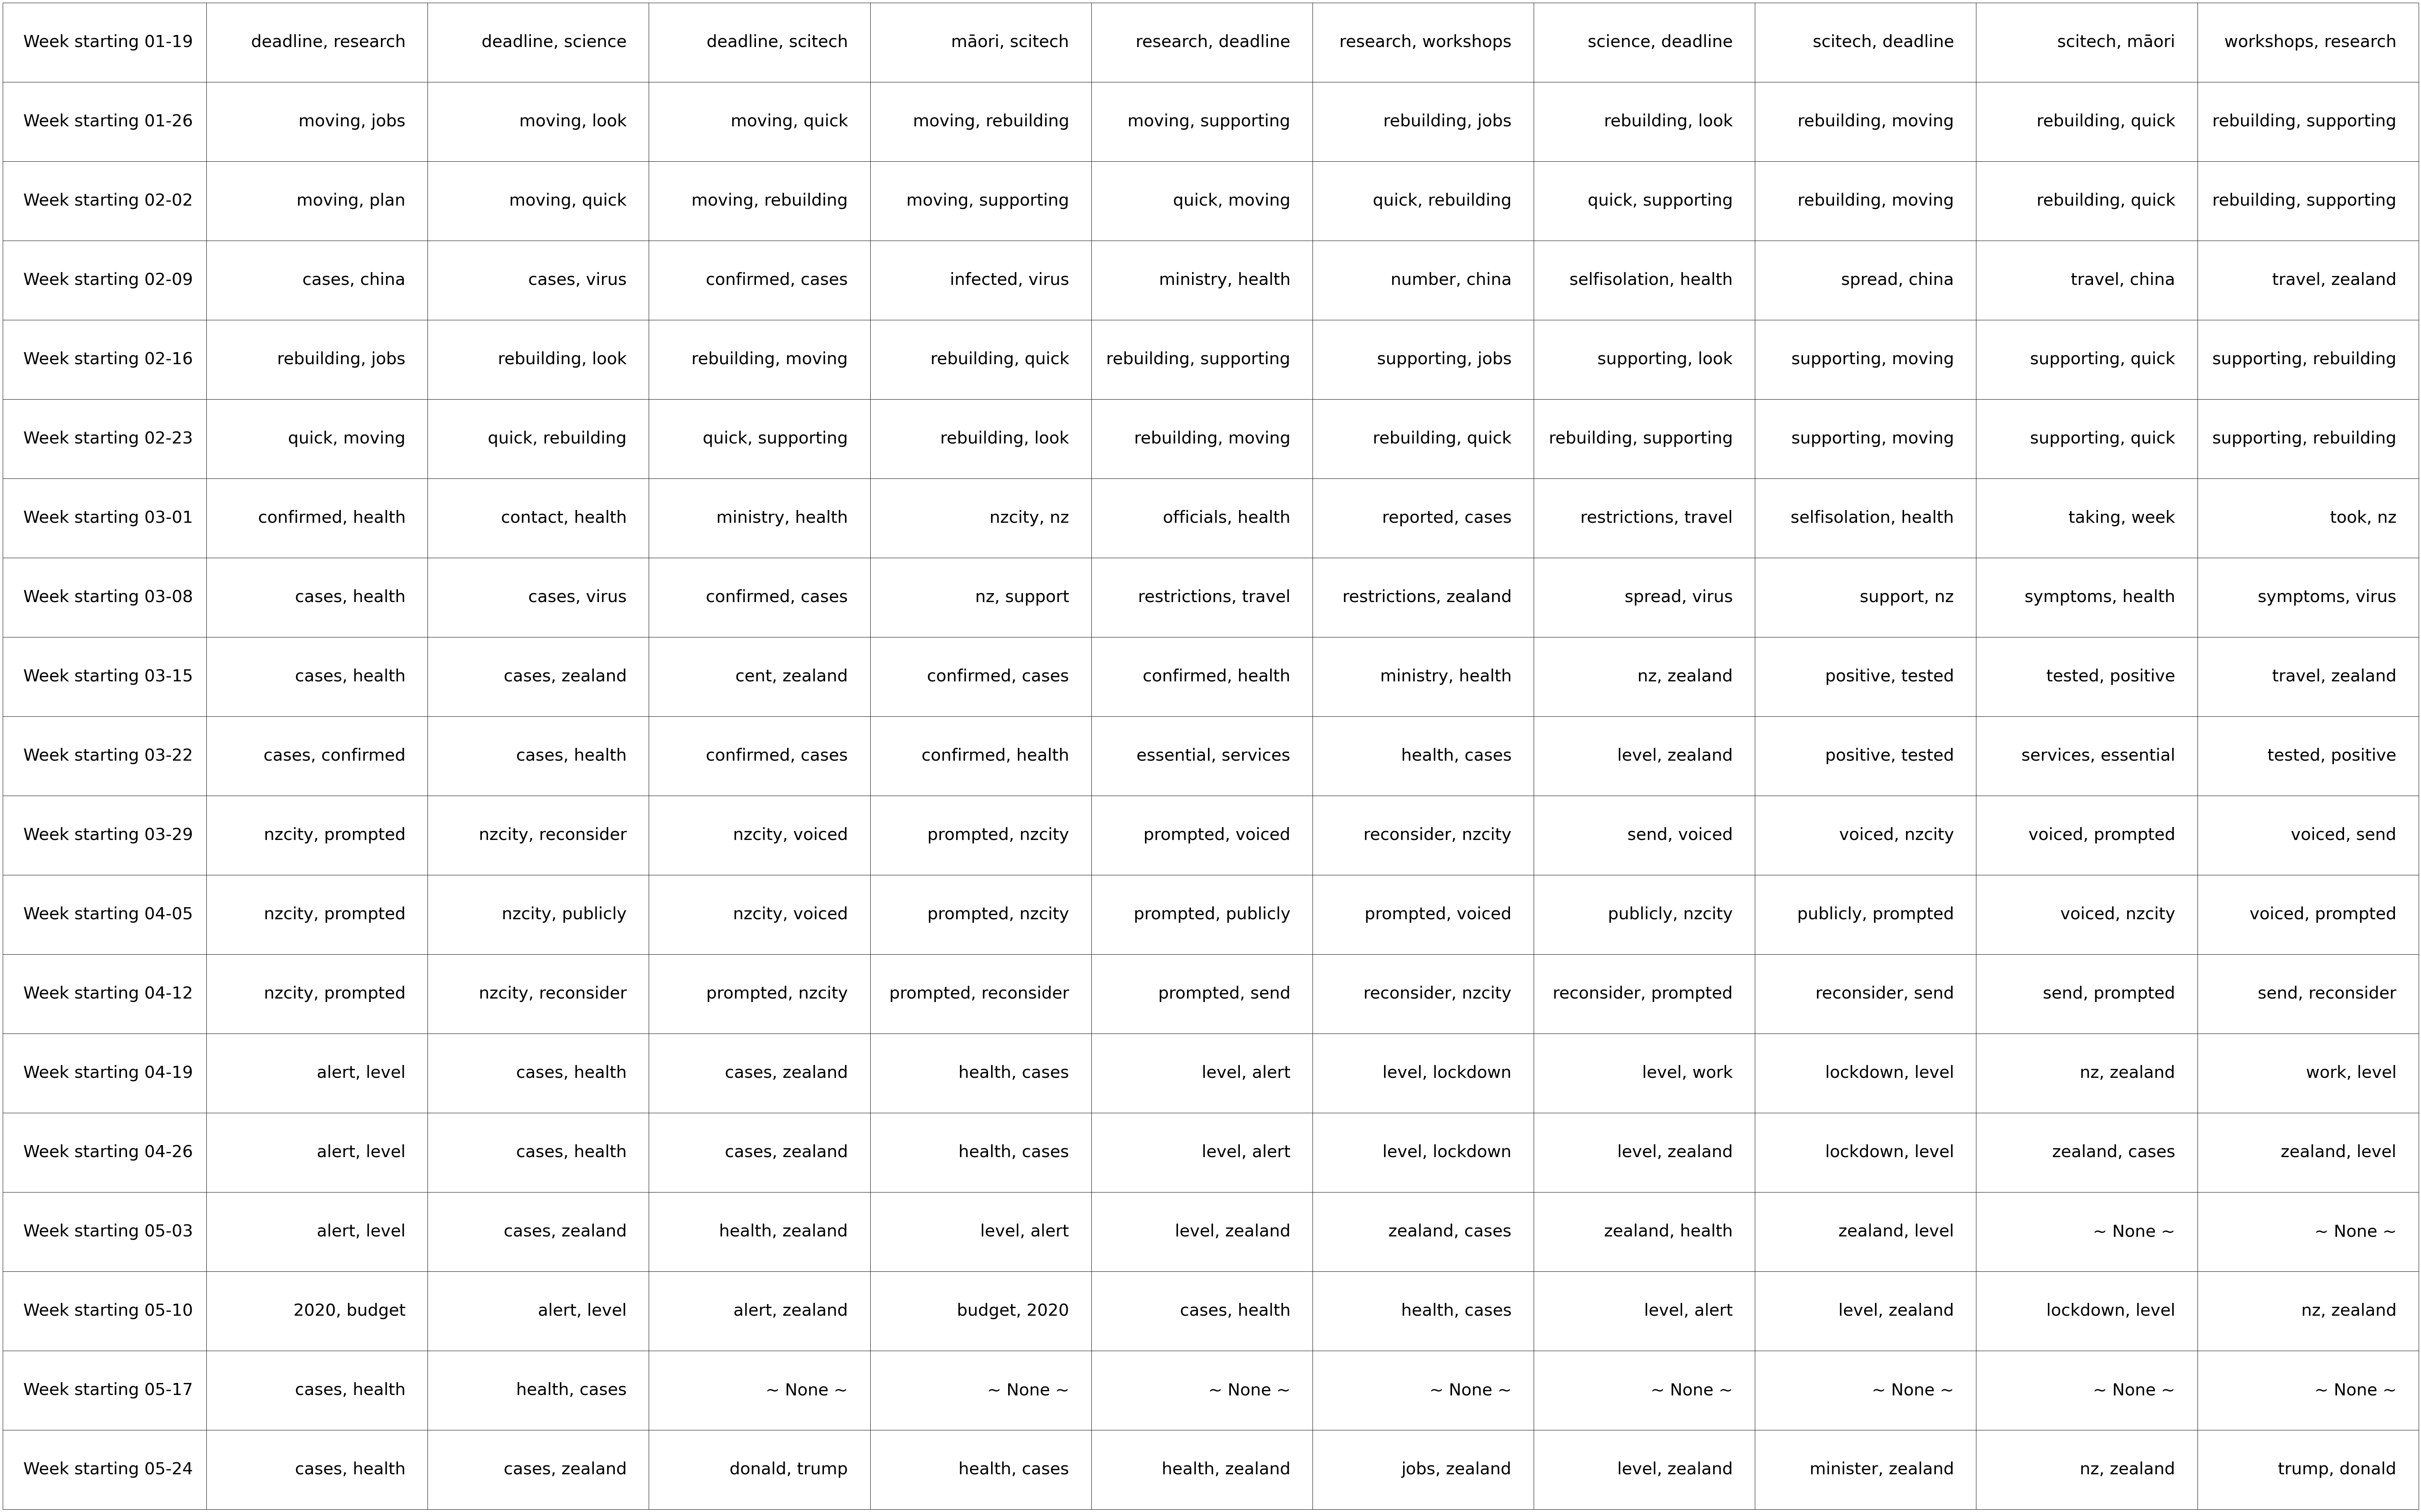

In [104]:
dirs = []
banlist = ["coronavirus","covid19"]
for i in os.listdir("out"):
    if i[-4:] == ".txt":
        dirs.append(i)
dirs= sorted(dirs)
y = sc.parallelize(dirs)
y = y.map(topten)


import matplotlib.pyplot as plt
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

z = y.collect()
#z = list(map(list, zip(*z)))
z = list(map(sorted, z)) 

for i in range(len(dirs)):
    dirs[i] = "Week starting " + dirs[i][5:-4]

tab = ax.table(cellText=z, rowLabels=dirs, loc='center')
tab.set_fontsize(100)
tab.scale(17, 17)

fig.tight_layout()

plt.show()

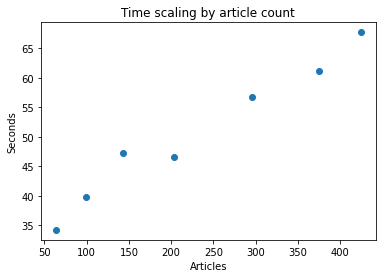

In [19]:
import matplotlib.pyplot as plt
f = [64,   99,     143,  203,    296,   375,    424]
g = [34.22, 39.76, 47.23, 46.65, 56.80, 61.10, 67.71]
plt.scatter(f,g)
plt.title('Time scaling by article count')
plt.xlabel('Articles')
plt.ylabel('Seconds')
plt.show()

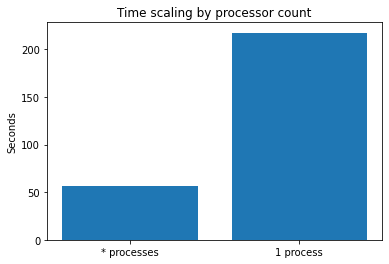

In [28]:
h = 56.80
i = 217.32
plt.bar(['* processes','1 process'],[h,i])
plt.title("Time scaling by processor count")
plt.ylabel('Seconds')
plt.show()